---
# 레저용품 EDA
---

## 0. 데이터 로드 & 전처리

In [1]:
import pandas as pd
import numpy as np
import scipy

from numpy import inf

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from random import choices,sample

import os
import gc
import pickle

import warnings
warnings.filterwarnings('ignore')

from datetime import timedelta, datetime
from tqdm import tqdm

plt.style.use('ggplot')

mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = "Malgun Gothic"

os.chdir("../../")
root_path = os.getcwd()

raw_file_path = os.path.join(root_path, "Bigcon2020_raw_file")
csv_file_path = os.path.join(root_path, "BigCon_2020/csv_files")
pickle_file_path = os.path.join(root_path, "BigCon_2020/pickle_files")
image_path = 'C:/Users/rears/OneDrive/바탕 화면/dacon_covid19/'

raw_file_folders = os.listdir(raw_file_path)

In [9]:
# 데이터 타입 변경을 통해 메모리 사용량 감소
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
folder_path = os.path.join(raw_file_path, raw_file_folders[4])

In [41]:
%%time
offline = pd.read_csv(os.path.join(csv_file_path, 'CARD_SPENDING_RESIDENT_KOR.csv'))

Wall time: 2.41 s


In [45]:
%%time
# online = pd.read_excel(os.path.join(folder_path,'2020 빅콘테스트_CJ올리브네트웍스_제공DB.xlsx'))
# online.to_csv(os.path.join(csv_file_path,"CJ_delivery.csv"), index=False, encoding='utf-8')

online = pd.read_csv(os.path.join(csv_file_path, 'CJ_delivery.csv'))

Wall time: 156 ms


In [47]:
weekdays = {0:'월', 1:'화', 2:'수', 3:'목', 4:'금', 5:'토', 6:'일'}

offline['STD_DD'] = pd.to_datetime(offline.STD_DD, format='%Y%m%d')
online['DL_YMD'] = pd.to_datetime(online['DL_YMD'].apply(lambda x: '20'+str(x)), format='%Y%m%d')

offline['WEEKDAY'] = offline.STD_DD.dt.dayofweek.apply(lambda x : '_'.join([str(x),weekdays.get(x)]))
online['WEEKDAY'] = online.DL_YMD.dt.dayofweek.apply(lambda x : '_'.join([str(x),weekdays.get(x)]))

# 년, 월, 년+월 추출
online['YEAR']  = online['DL_YMD'].dt.year
online['MONTH'] = online['DL_YMD'].dt.month
online['YEAR_MONTH'] = online['YEAR']*100 + online['MONTH']

# 주차 계산
offline['WEEK_NUM'] = offline['STD_DD'].dt.weekofyear
online['WEEK_NUM']  = online['DL_YMD'].dt.weekofyear

In [11]:
"""
# 요일 계산
weekdays = ['월', '화', '수', '목', '금', '토', '일']
offline['WEEKDAY'] = offline['STD_DD'].apply(lambda x:datetime.strptime(str(x), '%Y%m%d').weekday())
offline['WEEKDAY'] = offline['WEEKDAY'].apply(lambda x:str(x)+"_"+weekdays[x])
online['WEEKDAY']  = online['DL_YMD'].apply(lambda x:datetime.strptime(str(x), '%y%m%d').weekday())
online['WEEKDAY']  = online['WEEKDAY'].apply(lambda x:str(x)+"_"+weekdays[x])
"""

In [67]:
offline.head()

STD_DD  GU_CD DONG_CD MCT_CAT_CD SEX_CD  AGE_CD  USE_CNT  USE_AMT  \
0 2019-02-01  대구 중구     동인동         숙박      F      25       11      595   
1 2019-02-01  대구 중구     동인동         숙박      F      50        5      243   
2 2019-02-01  대구 중구     동인동         숙박      F      55        5       27   
3 2019-02-01  대구 중구     동인동         숙박      M      20       11      243   
4 2019-02-01  대구 중구     동인동         숙박      M      25       11      433   

     AVG_AMT  YEAR  MONTH  DAY  YEAR_MONTH WEEKDAY  WEEK_NUM  
0  54.090909  2019      2    1      201902     4_금         5  
1  48.600000  2019      2    1      201902     4_금         5  
2   5.400000  2019      2    1      201902     4_금         5  
3  22.090909  2019      2    1      201902     4_금         5  
4  39.363636  2019      2    1      201902     4_금         5

In [69]:
print(set(offline['MCT_CAT_CD']))
print("="*120)
print(set(online['DL_GD_LCLS_NM']))

{'수리서비스', '레저용품', '의료기관', '주방용구', '연료판매', '의복', '문화취미', '신변잡화', '직물', '광학제품', '보건위생', '요식업소', '가구', '유통업', '가전', '사무통신', '서적문구', '자동차판매', '전기', '음료식품', '숙박', '레저업소', '자동차 정비'}
{'생활건강', '패션의류', '도서/음반', '식품', '가구/인테리어', '스포츠/레저', '화장품/미용', '출산/육아', '패션잡화', '디지털/가전'}


## 1. 전년 동월 대비 비교

In [10]:
def graph_by_year_month_offline(category_name):
    # 카테고리에 속하는 데이터 뽑기
    category_df = offline.loc[offline['MCT_CAT_CD']==category_name, :]
    # YEAR, MONTH로 묶고 AMT, CNT 합 구하기
    category_df = category_df.groupby(['YEAR', 'MONTH'])[['USE_AMT', 'USE_CNT']].sum().reset_index()
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
    sns.barplot(x=category_df['MONTH'], y=category_df['USE_CNT'], hue='YEAR', data=category_df, ax=axes[0])
    sns.barplot(x=category_df['MONTH'], y=category_df['USE_AMT'], hue='YEAR', data=category_df, ax=axes[1])
    axes[0].set_title(category_name + "의 월별 소비횟수")
    axes[1].set_title(category_name + "의 월별 소비금액")

In [15]:
def graph_by_year_month_online(category_name):
    plt.figure(figsize=(8, 5)) 
    # 카테고리에 속하는 데이터 뽑기
    category_df = online.query('DL_GD_LCLS_NM=="{}"'.format(category_name))
    # YEAR, MONTH로 묶고 AMT, CNT 합 구하기
    category_df = category_df.groupby(['YEAR', 'MONTH'])[['INVC_CONT']].sum().reset_index() 

    sns.barplot(x='MONTH', y='INVC_CONT', hue='YEAR', data=category_df)
    plt.title(category_name + " 송장건수")

In [14]:
graph_by_year_month_offline("레저용품")

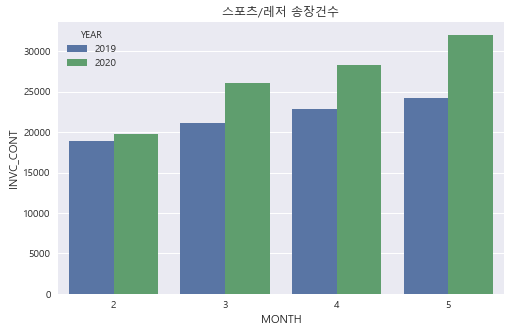

In [16]:
graph_by_year_month_online("스포츠/레저")

In [216]:
off_cat = '의복'
on_cat = '패션의류'

In [239]:
def graph_by_year_month_onoff(off_cat, on_cat):
    off_2019 = offline.loc[(offline.YEAR==2019) & (offline.MCT_CAT_CD.isin(off_cat))]
    off_2020 = offline.loc[(offline.YEAR==2020) & (offline.MCT_CAT_CD.isin(off_cat))]
    
    on_2019 = online.loc[(online.YEAR==2019) & (online.DL_GD_LCLS_NM.isin(on_cat))]
    on_2020 = online.loc[(online.YEAR==2020) & (online.DL_GD_LCLS_NM.isin(on_cat))]
    
    fig, ax = plt.subplots(ncols=2, figsize=(24,6))
    
    sns.barplot(
        data = off_2019.groupby(['WEEK_NUM'])['USE_CNT'].mean().reset_index(),
        x = 'WEEK_NUM',
        y = 'USE_CNT',
        ax = ax[0]
    )
    
    g1 = ax[0].twinx()
    g1 = sns.pointplot(
        data = on_2019.groupby(['WEEK_NUM'])['INVC_CONT'].mean().reset_index(),
        x = 'WEEK_NUM',
        y = 'INVC_CONT',
        color = 'k'
    )
    
    sns.barplot(
        data = off_2020.groupby(['WEEK_NUM'])['USE_CNT'].mean().reset_index(),
        x = 'WEEK_NUM',
        y = 'USE_CNT',
        ax = ax[1]
    )
    
    g2 = ax[1].twinx()
    g2 = sns.pointplot(
        data = on_2020.groupby(['WEEK_NUM'])['INVC_CONT'].mean().reset_index(),
        x = 'WEEK_NUM',
        y = 'INVC_CONT',
        color = 'k'
    )
    
    g1.axvspan(xmin=3.5, xmax=5.5, color='r', alpha=0.15)
    g2.axvspan(xmin=3.5, xmax=5.5, color='r', alpha=0.15)
    
    y1,y2 = g2.get_ybound()
    g1.set_ylim(y1,y2)
    
    plt.show()

### 의복&신변잡화 

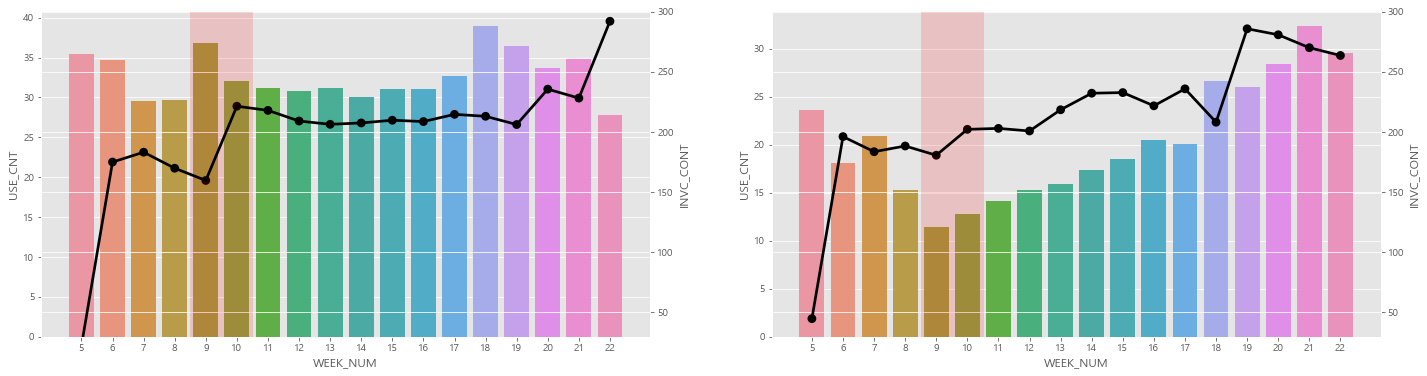

In [240]:
graph_by_year_month_onoff(['의복'],['패션의류'])

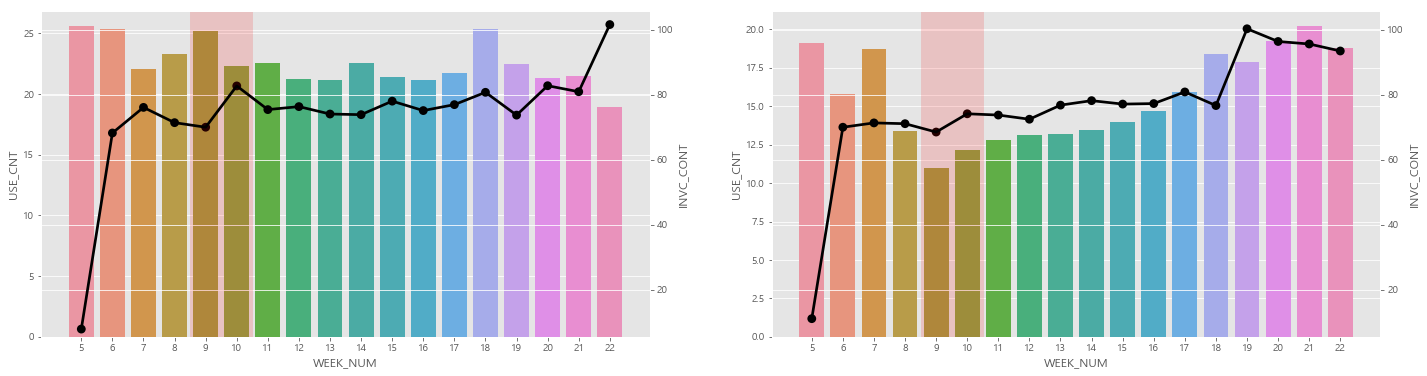

In [241]:
graph_by_year_month_onoff(['신변잡화'],['패션잡화'])

* 의복 => 오프라인 시장은 확실하게 줄었지만 온라인 시장의 경우 평균적으로 상승했음.  
* 패션잡화 => 의복과 온.오프라인 모두 거의 같은 모습

### 직물&가구&주방용구&가전 

In [229]:
graph_by_year_month_onoff(['직물','가구','주방용구','가전'], ['디지털/가전','가구/인테리어'])

### 어느지역에서 많이 팔리는지?

In [273]:
from sklearn.preprocessing import StandardScaler,RobustScaler

In [284]:
tmp_123 = offline.groupby(['DONG_CD','MCT_CAT_CD'])['USE_CNT'].sum().reset_index()
pivot_123=pd.crosstab(tmp_123.DONG_CD, tmp_123.MCT_CAT_CD, tmp_123.USE_CNT, aggfunc=sum, normalize='index')

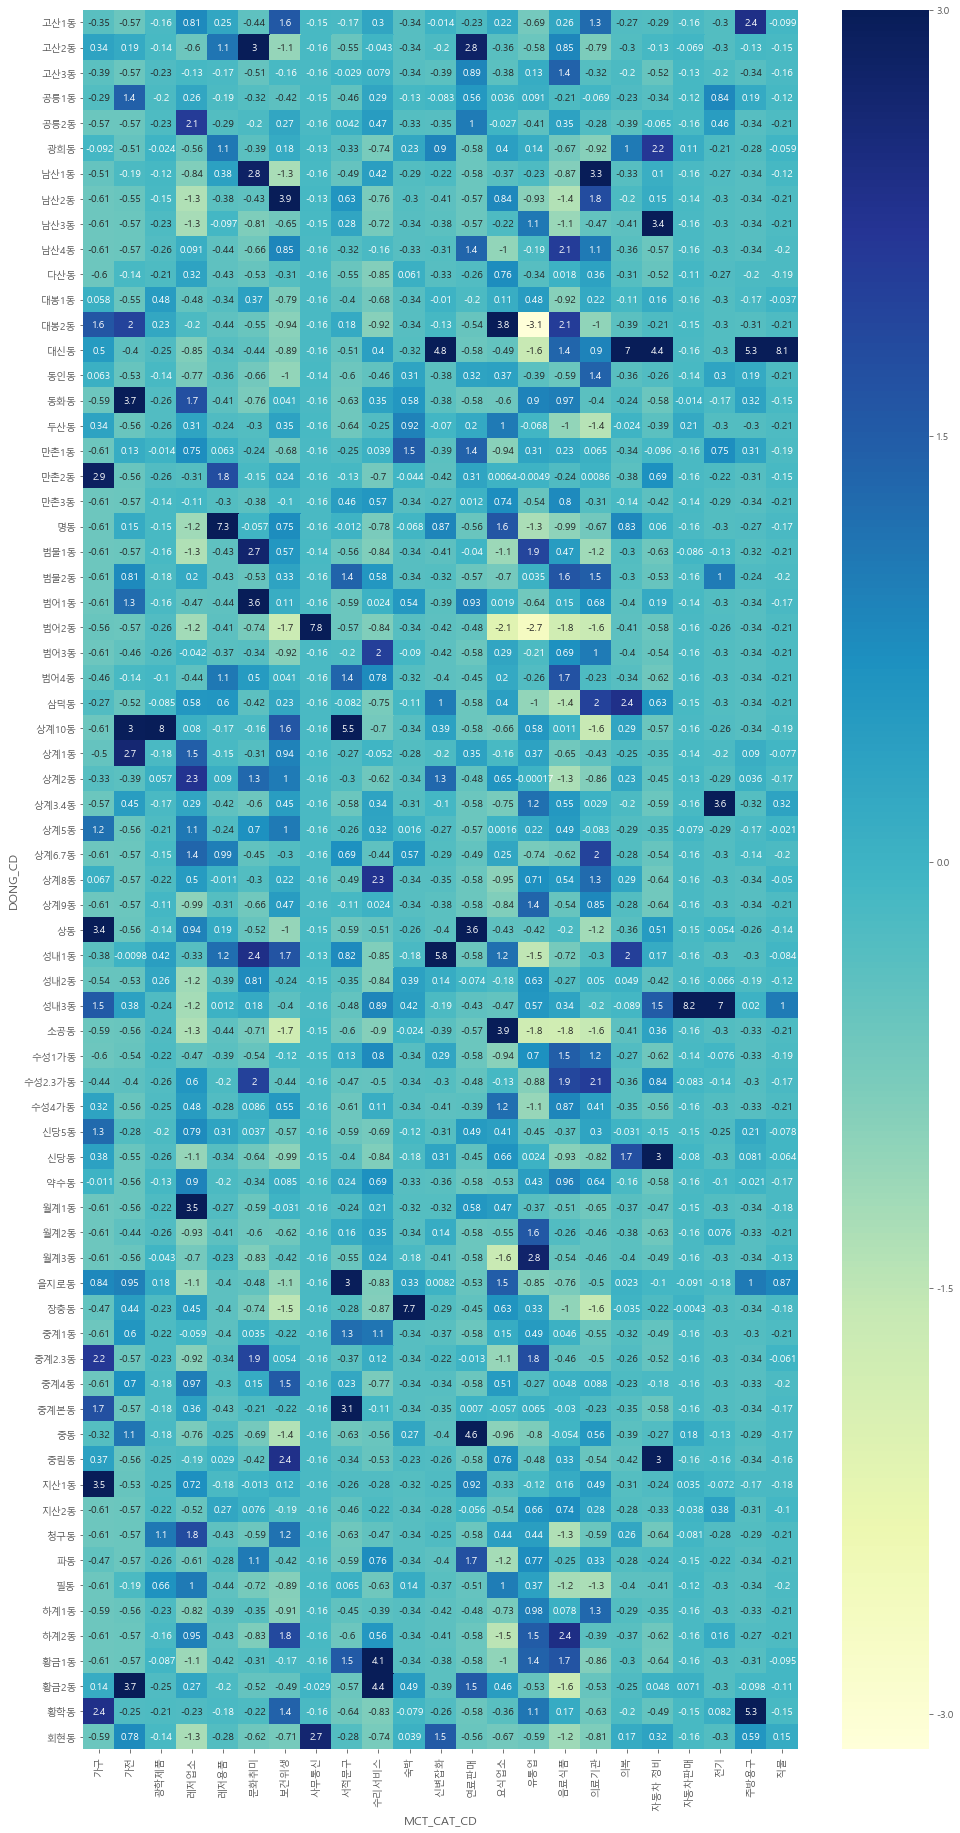

In [283]:
for col in pivot_123.columns:
    scaler = StandardScaler()
    pivot_123.loc[:,col] = scaler.fit_transform(pivot_123[[col]])

plt.figure(figsize=(16,32))
sns.heatmap(pivot_123, cmap='YlGnBu', annot=True, vmax=3)

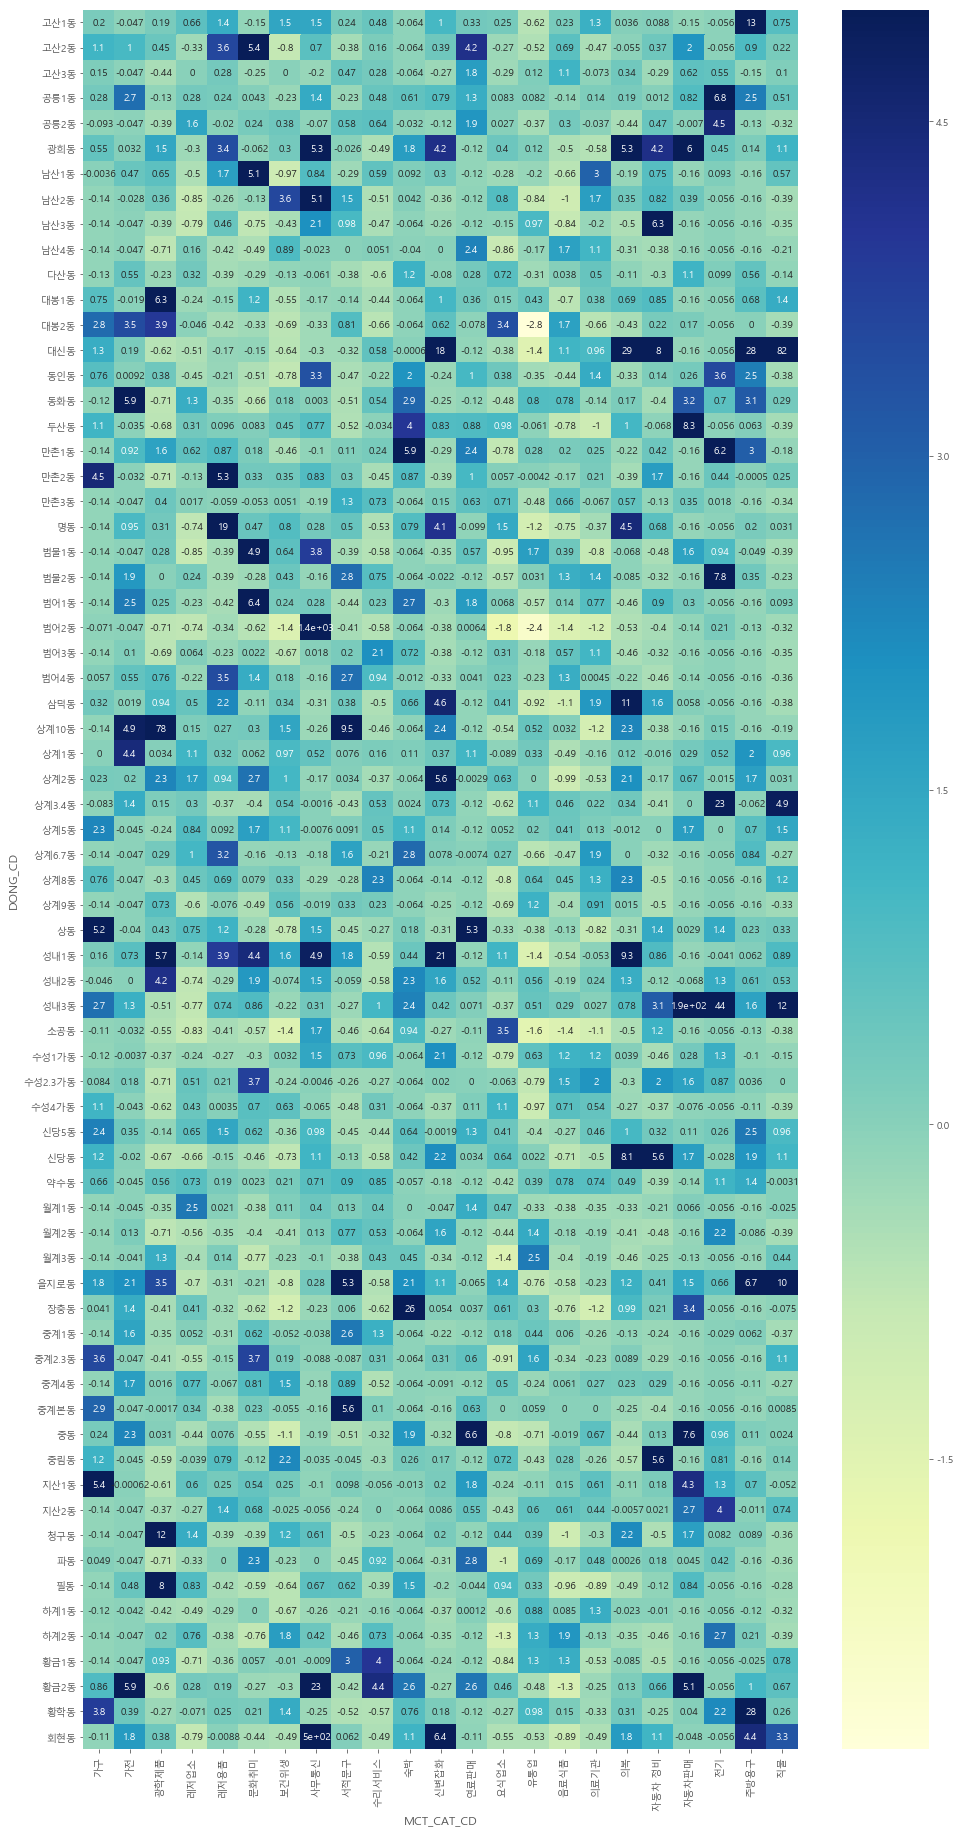

In [285]:
for col in pivot_123.columns:
    scaler = RobustScaler()
    pivot_123.loc[:,col] = scaler.fit_transform(pivot_123[[col]])

plt.figure(figsize=(16,32))
sns.heatmap(pivot_123, cmap='YlGnBu', annot=True, vmax=5)

In [288]:
tmp_123 = offline.groupby(['DONG_CD','MCT_CAT_CD'])['USE_AMT'].sum().reset_index()
pivot_123=pd.crosstab(tmp_123.DONG_CD, tmp_123.MCT_CAT_CD, tmp_123.USE_AMT, aggfunc=sum, normalize='index')

In [287]:
for col in pivot_123.columns:
    scaler = StandardScaler()
    pivot_123.loc[:,col] = scaler.fit_transform(pivot_123[[col]])

plt.figure(figsize=(16,32))
sns.heatmap(pivot_123, cmap='YlGnBu', annot=True, vmax=3)

In [289]:
for col in pivot_123.columns:
    scaler = RobustScaler()
    pivot_123.loc[:,col] = scaler.fit_transform(pivot_123[[col]])

plt.figure(figsize=(16,32))
sns.heatmap(pivot_123, cmap='YlGnBu', annot=True, vmax=5)

---
## 2. 오프라인 (카드)

In [24]:
# def graph_by_year_month(dataframe, category_name, category_column, year_month_column, aggregate_column, hue_column):
#     category_df = dataframe.loc[dataframe[category_column]==category_name, :]
#     category_df = category_df.groupby([year_month_column, hue_column])[[aggregate_column]].sum().reset_index()
    
#     plt.figure(figsize=(16, 5))
#     ax = sns.barplot(x=year_month_column, y=aggregate_column, hue=hue_column, data=category_df)
#     ax.set_title(category_name + "의 {}별 {}".format(hue_column, aggregate_column))
#     ax.legend(loc='lower right')
#     ax.axvline(x=3.5, color='r', linewidth=2, linestyle='--')

In [66]:
def graph_by_year_month_offline(category_name, hue_column):
    # 카테고리에 해당하는 데이터 뽑기
    category_df = offline.loc[offline['MCT_CAT_CD']==category_name, :]
    # YEAR_MONTH별로 CNT, AMT 합 구하기
    category_df = category_df.groupby(['YEAR_MONTH', hue_column])[['USE_CNT', 'USE_AMT']].sum().reset_index()
    
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 10))
    sns.barplot(x='YEAR_MONTH', y='USE_CNT', hue=hue_column, data=category_df, ax=axes[0])
    sns.barplot(x='YEAR_MONTH', y='USE_AMT', hue=hue_column, data=category_df, ax=axes[1])
    axes[0].set_title(category_name + "의 {}별 소비횟수".format(hue_column))
    axes[1].set_title(category_name + "의 {}별 소비금액".format(hue_column))
    axes[0].legend(loc='lower right')
    axes[1].legend(loc='lower right')
    axes[0].axvline(x=3.5, color='r', linewidth=2, linestyle='--')
    axes[1].axvline(x=3.5, color='r', linewidth=2, linestyle='--')
    
    
def graph_by_month_number_offline(category_name, hue_column):
    # 카테고리에 해당하는 데이터 뽑기
    category_df = offline.loc[offline['MCT_CAT_CD']==category_name, :]
    # 주차별로 CNT, AMT 합 구하기
    category_df = category_df.groupby(['YEAR', 'WEEK_NUM', hue_column])[['USE_CNT', 'USE_AMT']].sum().reset_index()
    df_2019 = category_df.query('YEAR==2019')
    df_2020 = category_df.query('YEAR==2020')
    
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(16, 20))
    sns.barplot(x='WEEK_NUM', y='USE_CNT', hue=hue_column, data=df_2019, ax=axes[0], palette='Set2')
    sns.barplot(x='WEEK_NUM', y='USE_CNT', hue=hue_column, data=df_2020, ax=axes[1], palette='Set2')
    sns.barplot(x='WEEK_NUM', y='USE_AMT', hue=hue_column, data=df_2019, ax=axes[2], palette='Set2')
    sns.barplot(x='WEEK_NUM', y='USE_AMT', hue=hue_column, data=df_2020, ax=axes[3], palette='Set2')
    
    aggregate_columns = ['USE_CNT', 'USE_AMT']
    years = [2019, 2020]
    for i in [0, 1, 2, 3]:
        axes[i].set_title(category_name + "{}년의 {}별 {}".format(years[i%2], hue_column, aggregate_columns[i//2]))
        axes[i].legend(loc='lower right')
        axes[i].set_ylim([0, category_df[aggregate_columns[i//2]].max()*1.1])
        axes[i].axvline(x=2.5, color='r', linewidth=2, linestyle='--')
        axes[i].axvline(x=6.5, color='r', linewidth=2, linestyle='--')
        axes[i].axvline(x=14.5, color='g', linewidth=2, linestyle='--')
        axes[i].text(x=2.5, y=category_df[aggregate_columns[i//2]].max()*0.9, s="　코로나 확산기(8~11주)")
        axes[i].text(x=14.5, y=category_df[aggregate_columns[i//2]].max()*0.9, s="　재난지원금 지급주")


def graph_by_weekday_offline(category_name, hue_column):
    # 카테고리에 해당하는 데이터 뽑기
    category_df = offline.loc[offline['MCT_CAT_CD']==category_name, :]
    # 년도 + 요일별로 CNT, AMT 합 구하기
    category_df = category_df.groupby(['YEAR', 'WEEKDAY', hue_column])[['USE_CNT', 'USE_AMT']].sum().reset_index()
    df_2019 = category_df.query('YEAR==2019')
    df_2020 = category_df.query('YEAR==2020')
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
    sns.barplot(x=hue_column, y='USE_CNT', hue='WEEKDAY', data=df_2019, ax=axes[0][0])
    sns.barplot(x=hue_column, y='USE_CNT', hue='WEEKDAY', data=df_2020, ax=axes[0][1])
    sns.barplot(x=hue_column, y='USE_AMT', hue='WEEKDAY', data=df_2019, ax=axes[1][0])
    sns.barplot(x=hue_column, y='USE_AMT', hue='WEEKDAY', data=df_2020, ax=axes[1][1])
    
    aggregate_columns = ['USE_CNT', 'USE_AMT']
    years = [2019, 2020]
    for i in [0, 1]:
        for j in [0, 1]:
            axes[i][j].set_ylim([0, df_2019[aggregate_columns[i]].max()*1.1])
            axes[i][j].set_title("{}년 요일별 {}".format(years[j], aggregate_columns[i]))
    
    
def graph_by_same_month_ratio_offline(category_name, hue_column):
    # 카테고리에 해당하는 데이터 뽑기
    category_df = offline.loc[offline['MCT_CAT_CD']==category_name, :]
    # 동 내 YEAR_MONTH, HUE(성별, 연령) CNT, AMT 합 구하기
    category_df = category_df.groupby(['DONG_CD', 'YEAR_MONTH', hue_column])[['USE_CNT', 'USE_AMT']].sum().reset_index()

    result_df = pd.DataFrame()
    DONGs  = category_df['DONG_CD'].unique()
    LISTs  = category_df[hue_column].unique()

    for dong in DONGs:
        dong_temp = category_df.loc[category_df['DONG_CD']==dong, :]
        for select in LISTs:
            temp = dong_temp.loc[dong_temp[hue_column]==select, :]
            for year_month in [201902, 201903, 201904, 201905]:
                try:
                    year_2019_cnt, year_2019_amt = temp.loc[temp['YEAR_MONTH']==year_month, ['USE_CNT', 'USE_AMT']].values[0]
                    year_2020_cnt, year_2020_amt = temp.loc[temp['YEAR_MONTH']==year_month+100, ['USE_CNT', 'USE_AMT']].values[0]
                    # 전년 동월 대비 올해의 CNT 비율
                    # 전년 동월 대비 올해의 AMT 비율
                    result_df = result_df.append({   "dong":dong,
                                                     hue_column:select,
                                                     "month":round(year_month-201900, 0),
                                                     "cnt_ratio":year_2020_cnt/year_2019_cnt,
                                                     "amt_ratio":year_2020_amt/year_2019_amt}, ignore_index=True)
                except:
                    continue
                    #print(dong, age, year_month)
                    
    display(result_df[['cnt_ratio', 'amt_ratio']].describe())
    # 극단치 때문에 median 사용
    result_median_df = result_df.groupby(['month', hue_column])[['amt_ratio', 'cnt_ratio']].median().reset_index() 
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
    sns.boxplot(result_df['cnt_ratio'], ax=axes[0][0])
    sns.boxplot(result_df['amt_ratio'], ax=axes[0][1])
    sns.barplot(x='month', y='cnt_ratio', hue=hue_column, data=result_median_df, ax=axes[1][0])
    sns.barplot(x='month', y='amt_ratio', hue=hue_column, data=result_median_df, ax=axes[1][1])    

    axes[0][0].set_title("cnt_ratio BOXPLOT"); 
    axes[0][1].set_title("amt_ratio BOXPLOT")
    axes[1][0].legend(loc='lower right'); 
    axes[1][1].legend(loc='lower right')
    axes[1][0].axhline(y=1, color='r', linewidth=2, linestyle='--'); 
    axes[1][1].axhline(y=1, color='r', linewidth=2, linestyle='--')
    axes[1][0].set_title("2019년 대비 2020년 동월의 cnt 비율의 median")
    axes[1][1].set_title("2019년 대비 2020년 동월의 amt 비율의 median")
    
    
def graph_by_increase_rate_offline(category_name, hue_column):
    # 카테고리에 해당하는 데이터 뽑기
    category_df = offline.loc[offline['MCT_CAT_CD']==category_name, :]
    # 동 내 YEAR_MONTH, HUE(성별, 연령) CNT, AMT 합 구하기
    category_df = category_df.groupby(['DONG_CD', 'YEAR_MONTH', hue_column])[['USE_CNT', 'USE_AMT']].sum().reset_index()

    result_df = pd.DataFrame()
    DONGs = category_df['DONG_CD'].unique()
    LISTs  = category_df[hue_column].unique()

    for dong in DONGs:
        dong_temp = category_df.loc[category_df['DONG_CD']==dong, :]
        for select in LISTs:
            temp = dong_temp.loc[dong_temp[hue_column]==select, :]
            try:
                year_2019 = temp.loc[temp['YEAR_MONTH']<202000, ['USE_CNT', 'USE_AMT']]
                year_2019_cnt = ((year_2019['USE_CNT'] - year_2019['USE_CNT'].shift(1)).dropna() / year_2019['USE_CNT'].shift(1).dropna()).values
                year_2019_amt = ((year_2019['USE_AMT'] - year_2019['USE_AMT'].shift(1)).dropna() / year_2019['USE_AMT'].shift(1).dropna()).values

                year_2020 = temp.loc[temp['YEAR_MONTH']>202000, ['USE_CNT', 'USE_AMT']]
                year_2020_cnt = ((year_2020['USE_CNT'] - year_2020['USE_CNT'].shift(1)).dropna() / year_2020['USE_CNT'].shift(1).dropna()).values
                year_2020_amt = ((year_2020['USE_AMT'] - year_2020['USE_AMT'].shift(1)).dropna() / year_2020['USE_AMT'].shift(1).dropna()).values
                
                # 2019년 2월 대비 3월 AMT/CNT 증가율 (3월 대비 4월, 4월 대비 5월도 구함)
                # 2020년 2월 대비 3월 AMT/CNT 증가율 (3월 대비 4월, 4월 대비 5월도 구함)
                for i, month in enumerate(['month_2_3', 'month_3_4', 'month_4_5']):
                    result_df = result_df.append({"year":2019,
                                                  "month":month,
                                                  "dong":dong,
                                                  hue_column:select,
                                                  "cnt_ratio":year_2019_cnt[i],
                                                  "amt_ratio":year_2019_amt[i]}, ignore_index=True)
                    result_df = result_df.append({"year":2020,
                                                  "month":month,
                                                  "dong":dong,
                                                  hue_column:select,
                                                  "cnt_ratio":year_2020_cnt[i],
                                                  "amt_ratio":year_2020_amt[i]}, ignore_index=True)
            except:
                continue
                #print(dong, age, year_month)
                
    result_df = result_df[['year', 'month', 'dong', hue_column, 'cnt_ratio', 'amt_ratio']]
    result_df['year'] = result_df['year'].map(int)
    temp = result_df.groupby(['year', 'month', hue_column])[['cnt_ratio', 'amt_ratio']].median().reset_index()

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
    year_2019 = temp.query('year==2019')
    year_2020 = temp.query('year==2020')
    sns.lineplot(x='month', y='cnt_ratio', hue=hue_column, data=year_2019, ax=axes[0][0])
    sns.lineplot(x='month', y='cnt_ratio', hue=hue_column, data=year_2020, ax=axes[0][1])
    sns.lineplot(x='month', y='amt_ratio', hue=hue_column, data=year_2019, ax=axes[1][0])
    sns.lineplot(x='month', y='amt_ratio', hue=hue_column, data=year_2020, ax=axes[1][1])

    for row in [0, 1]:
        name = "cnt_ratio" if row == 0 else "amt_ratio"
        axes[row][0].set_title("2019년 " + name + " (전 월 대비 증가율)의 중위수")
        axes[row][1].set_title("2020년 " + name + " (전 월 대비 증가율)의 중위수")
        for col in [0, 1]:
            axes[row][col].axhline(y=0, color='r', linewidth=2, linestyle='--')
            axes[row][col].set_ylim([temp[name].min()-0.1, temp[name].max()+0.1])
            if hue_column == "age":
                axes[row][col].legend([20, 25, 30, 35, 40, 45, 50, 55, 60, 65], loc='upper left')
            else:
                axes[row][col].legend(['M', 'F'], loc='upper left')

### 1)연령별

In [37]:
graph_by_year_month_offline("레저용품", "AGE_CD")
# 25~29세의 소비횟수/금액이 가장 많다
# 그 다음이 45~49세의 소비횟수/금액
# 60세 이상의 소비횟수/소비금액 최하

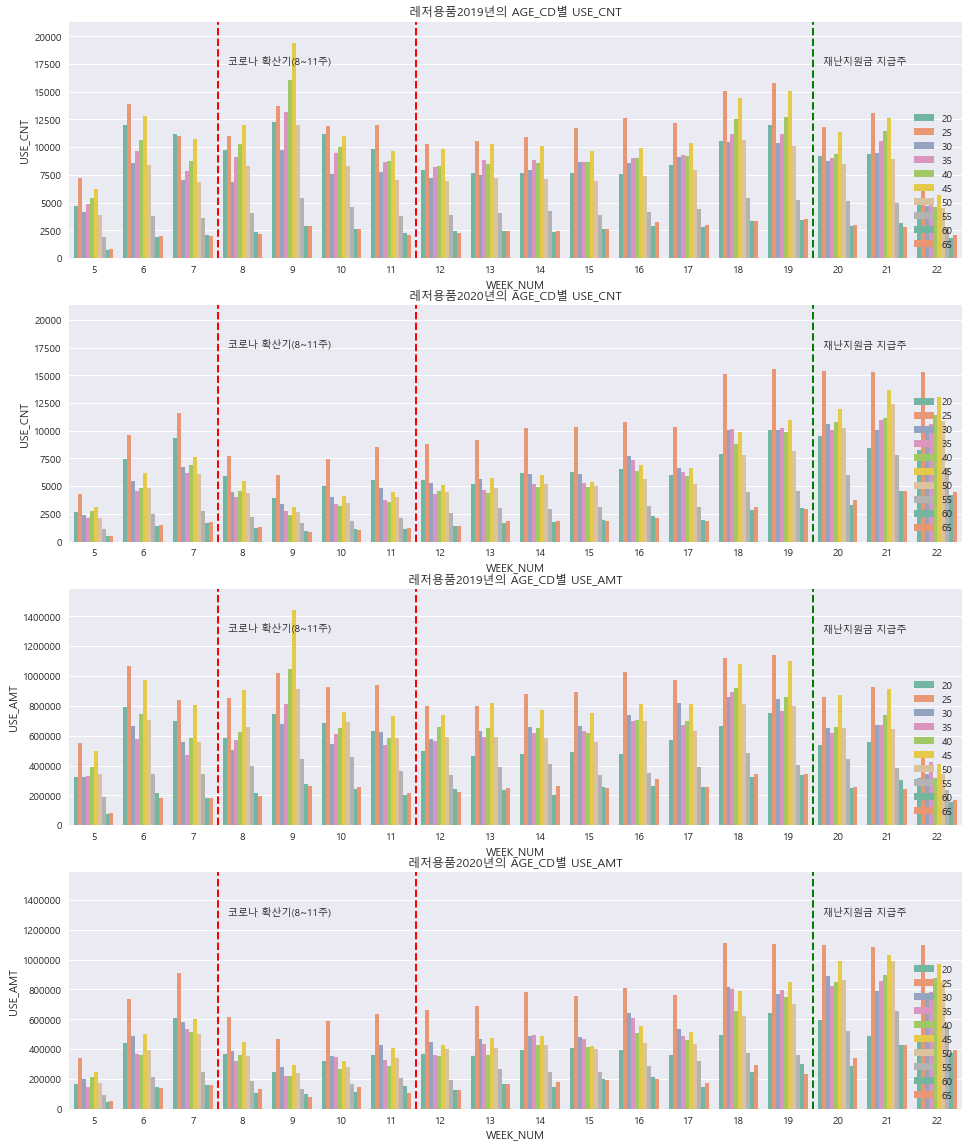

In [67]:
graph_by_month_number_offline("레저용품", "AGE_CD")

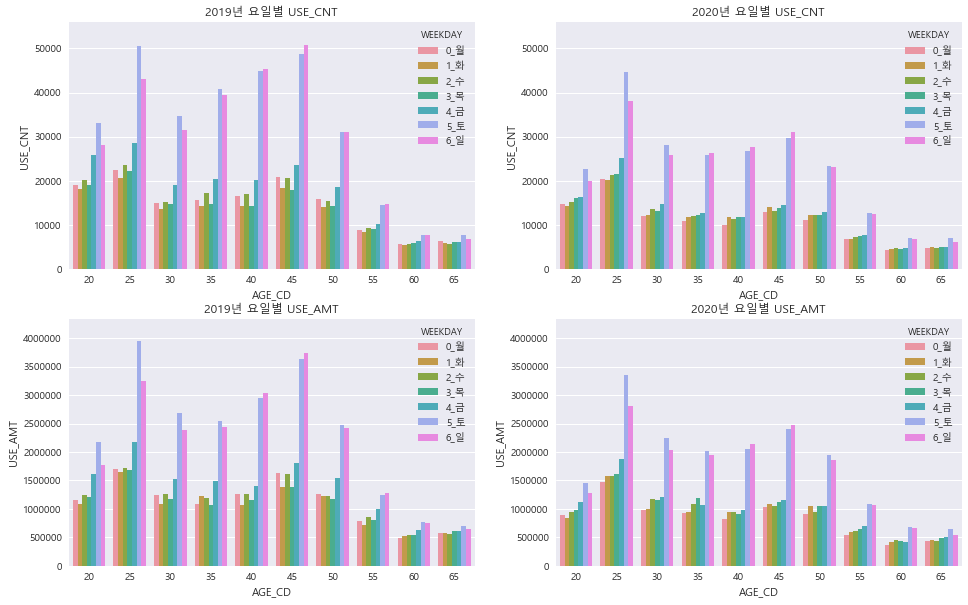

In [39]:
graph_by_weekday_offline("레저용품", "AGE_CD")

# 20~60세까지는 평일 대비 주말에 레저용품 구매건수/구매금액이 월등히 높다
# 60세 이상의 경우 평일과 주발이 크게 차이나지 않는다.

In [40]:
graph_by_same_month_ratio_offline("레저용품", "AGE_CD")

# 전년 동월 CNT 대비 올해 동월 CNT가 84인 경우 존재 -> 극단치
# 전년 동월 AMT 대비 올해 동월 AMT가 136인 경우 존재 -> 극단치
# -> 중위수를 찍어보았다
# 5월의 경우 전년 동월 대비 올해 AMT가 모두 1이상 !

cnt_ratio    amt_ratio
count  1889.000000  1889.000000
mean      0.983002     2.032301
std       2.302560     6.943434
min       0.017606     0.001363
25%       0.394231     0.341970
50%       0.648362     0.672269
75%       1.022472     1.348194
max      84.000000   136.735931

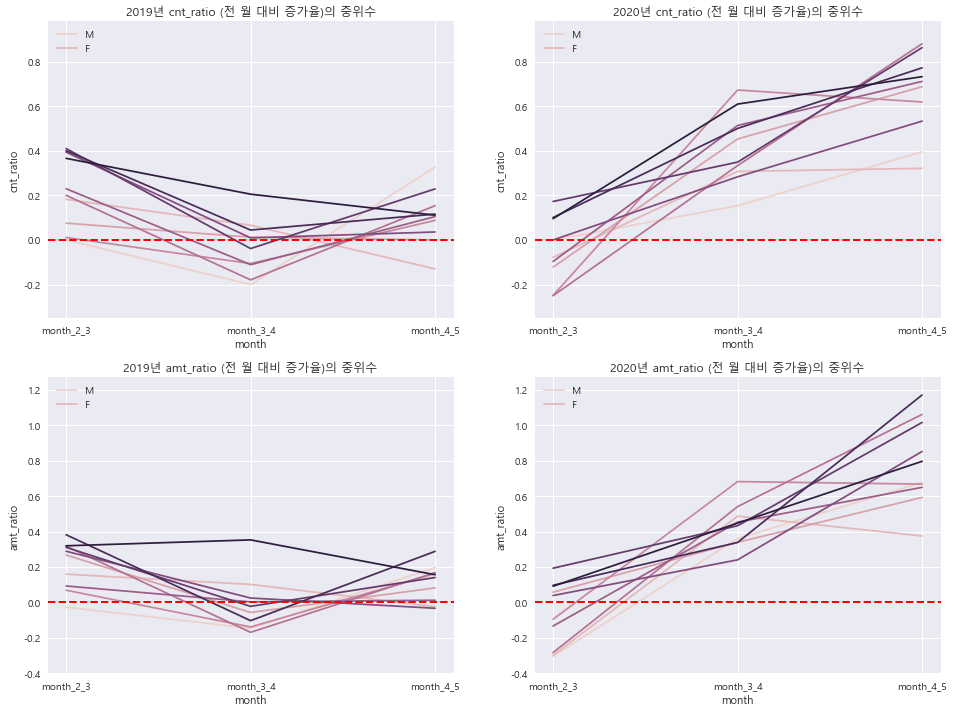

In [41]:
graph_by_increase_rate_offline("레저용품", "AGE_CD")

# 2019년에는 2월 대비 3월 증가하다가 3월 대비 4월은 감소, 4월 대비 5월은 다시 증가하는 경향을 보임
# 2020년에는 3월 대비 4월에 cnt 증가 / 4월 대비 5월에도 cnt 증가 (증가속도 빨라짐)
# 2020년에는 3월 대비 4월에 amt 증가 / 4월 대비 5월에도 amt 증가 (증가속도 빨라짐)

### 2) 성별

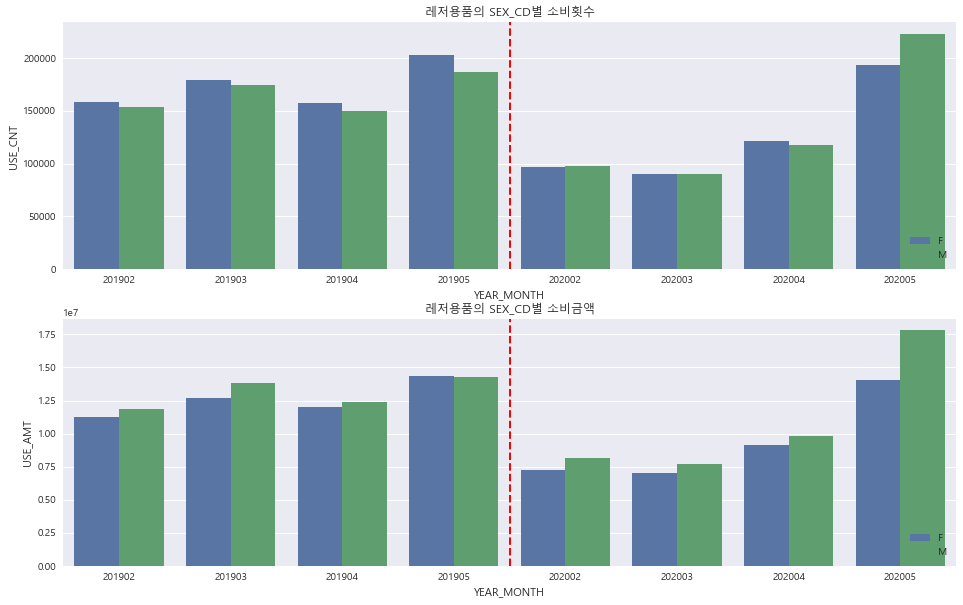

In [70]:
graph_by_year_month_offline("레저용품", "SEX_CD")

# 2019년에는 여성이 남성보다 소비횟수 높다. 2020년에도 지속되지만 2020년 5월에는 남성의 소비횟수가 여성 추월
# 2019년에는 남성이 여성보다 소비금액 높다. 2020년에도 이러한 경향이 지속

In [71]:
graph_by_month_number_offline("레저용품", "SEX_CD")

In [72]:
graph_by_weekday_offline("레저용품", "SEX_CD")

# 남성/여성 모두 평일 대비 주말에 레저용품 구매횟수/구매건수 높다

In [73]:
graph_by_same_month_ratio_offline("레저용품", "SEX_CD")

# 2, 3, 4월은 모두 전년 동월 대비 AMT, CNT가 낮은 수준
# 하지만 5월의 경우 남성은 AMT, CNT가 1이상 (여성은 1미만) -> 5월에 남성에게서 레저용품 구매횟수/구매건수 증가

cnt_ratio   amt_ratio
count  494.000000  494.000000
mean     0.911061    1.589674
std      1.235534    5.715312
min      0.014368    0.025399
25%      0.386138    0.425218
50%      0.619714    0.680637
75%      1.000000    1.234618
max     13.333333  111.000000

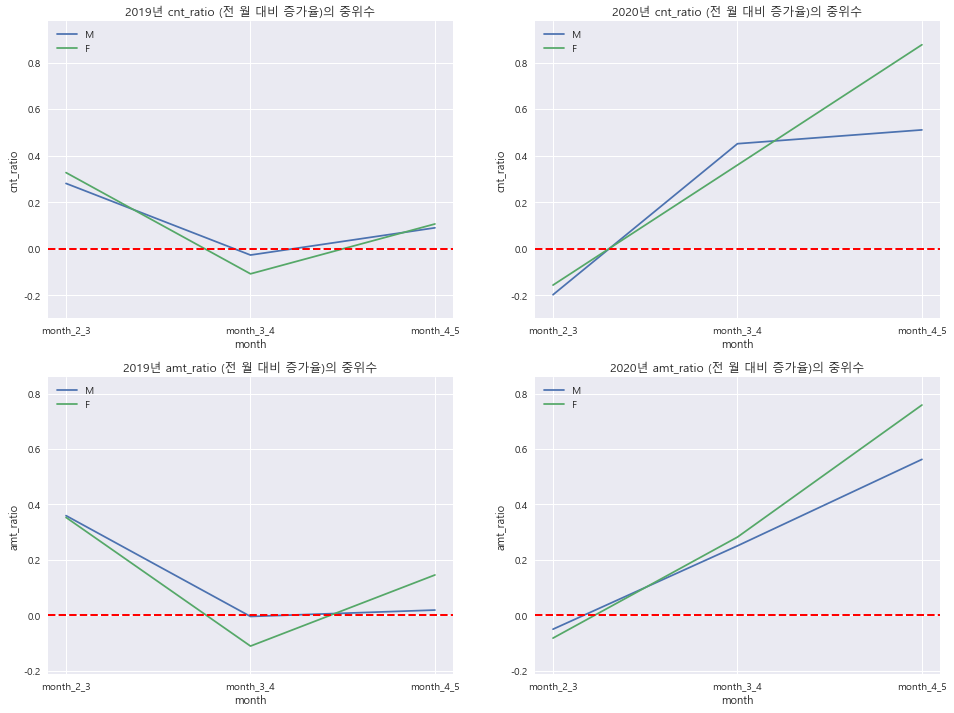

In [74]:
graph_by_increase_rate_offline("레저용품", "SEX_CD")

# 2019 : 2월 대비 3월 증가, 3월 대비 4월 감소, 4월 대비 5월 증가
# 2020 : 2월 대비 3월 감소, 3월 대비 4월 증가, 4월 대비 5월 증가

---
## 3. 온라인 (물류)

In [75]:
def graph_by_year_month_weekday_online(category_name):
    
    fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
    category_df1 = online.groupby(['DL_GD_LCLS_NM', 'YEAR', 'MONTH'])[['INVC_CONT']].sum().reset_index()
    category_df1 = category_df1.query('DL_GD_LCLS_NM=="{}"'.format(category_name))
    
    category_df2 = online.groupby(['DL_GD_LCLS_NM', 'YEAR', 'WEEKDAY'])[['INVC_CONT']].sum().reset_index()
    category_df2 = category_df2.query('DL_GD_LCLS_NM=="{}"'.format(category_name))

    sns.barplot(x='MONTH',   y='INVC_CONT', hue='YEAR', data=category_df1, ax=axes[0])
    sns.barplot(x='WEEKDAY', y='INVC_CONT', hue='YEAR', data=category_df2, ax=axes[1])
    axes[0].set_title(category_name + " 송장건수")
    axes[1].set_title(category_name + " 송장건수")
    
def graph_by_same_month_ratio_online(category_name):    
    category_df = online.loc[online['DL_GD_LCLS_NM']==category_name, :]
    category_df = category_df.groupby(['HDNG_NM', 'YEAR_MONTH'])[['INVC_CONT']].sum().reset_index()

    result_df = pd.DataFrame()
    DONGs = category_df['HDNG_NM'].unique()

    for dong in DONGs:
        temp = category_df.loc[category_df['HDNG_NM']==dong, :]
        for year_month in [201902, 201903, 201904, 201905]:
            try:
                year_2019 = temp.loc[temp['YEAR_MONTH']==year_month, ['INVC_CONT']].values[0][0]
                year_2020 = temp.loc[temp['YEAR_MONTH']==year_month+100, ['INVC_CONT']].values[0][0]
                result_df = result_df.append({   "dong":dong,
                                                 "month":round(year_month-201900, 0),
                                                 "invc_ratio":year_2020/year_2019}, ignore_index=True)
            except:
                continue
                #print(dong, age, year_month)

    display(result_df[['invc_ratio']].describe())
    result_median_df = result_df.groupby(['month'])[['invc_ratio']].median().reset_index() # 극단치 때문에 median 사용

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 10))
    sns.boxplot(result_df['invc_ratio'], ax=axes[0])
    sns.barplot(x='month', y='invc_ratio', data=result_median_df, ax=axes[1])

    axes[0].set_title("cnt_ratio BOXPLOT")
    axes[1].set_title("2019년 대비 2020년 동월의 송장건수 비율의 median")
    axes[1].axhline(y=1, color='r', linewidth=2, linestyle='--')


def graph_by_increase_rate_online(category_name):
    category_df = online.loc[online['DL_GD_LCLS_NM']==category_name, :]
    category_df = category_df.groupby(['HDNG_NM', 'YEAR_MONTH'])[['INVC_CONT']].sum().reset_index()

    result_df = pd.DataFrame()
    DONGs = category_df['HDNG_NM'].unique()

    for dong in DONGs:
        temp = category_df.loc[category_df['HDNG_NM']==dong, :]
        try:
            year_2019 = temp.loc[temp['YEAR_MONTH']<202000, ['INVC_CONT']]
            year_2019 = ((year_2019['INVC_CONT'] - year_2019['INVC_CONT'].shift(1)).dropna() / year_2019['INVC_CONT'].shift(1).dropna()).values

            year_2020 = temp.loc[temp['YEAR_MONTH']>202000, ['INVC_CONT']]
            year_2020 = ((year_2020['INVC_CONT'] - year_2020['INVC_CONT'].shift(1)).dropna() / year_2020['INVC_CONT'].shift(1).dropna()).values

            for i, month in enumerate(['month_2_3', 'month_3_4', 'month_4_5']):
                result_df = result_df.append({  "year":2019,
                                                "month":month,
                                                "dong":dong,
                                                "invc_ratio":year_2019[i]}, ignore_index=True)

                result_df = result_df.append({  "year":2020,
                                                "month":month,
                                                "dong":dong,
                                                "invc_ratio":year_2020[i]}, ignore_index=True)
        except:
            continue
            #print(dong, age, year_month)

    result_df = result_df[['year', 'month', 'dong','invc_ratio']]
    result_df['year'] = result_df['year'].map(int)
    temp = result_df.groupby(['year', 'month'])[['invc_ratio']].median().reset_index()

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    year_2019 = temp.query('year==2019')
    year_2020 = temp.query('year==2020')
    sns.lineplot(x='month', y='invc_ratio', data=year_2019, ax=axes[0])
    sns.lineplot(x='month', y='invc_ratio', data=year_2020, ax=axes[1])

    axes[0].set_title("2019년 송장건수 (전 월 대비 증가율)의 중위수")
    axes[1].set_title("2020년 송장건수 (전 월 대비 증가율)의 중위수")
    axes[0].axhline(y=0, color='r', linewidth=2, linestyle='--')
    axes[1].axhline(y=0, color='r', linewidth=2, linestyle='--')
    axes[0].set_ylim([temp['invc_ratio'].min()-0.1, temp['invc_ratio'].max()+0.1])
    axes[1].set_ylim([temp['invc_ratio'].min()-0.1, temp['invc_ratio'].max()+0.1])


In [76]:
online_category_name = "스포츠/레저"

invc_ratio
count  276.000000
mean     1.245173
std      0.226993
min      0.682131
25%      1.050678
50%      1.271551
75%      1.393756
max      1.944134

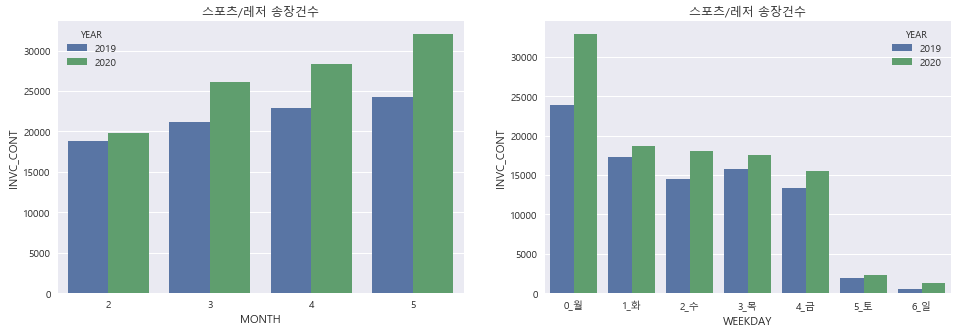

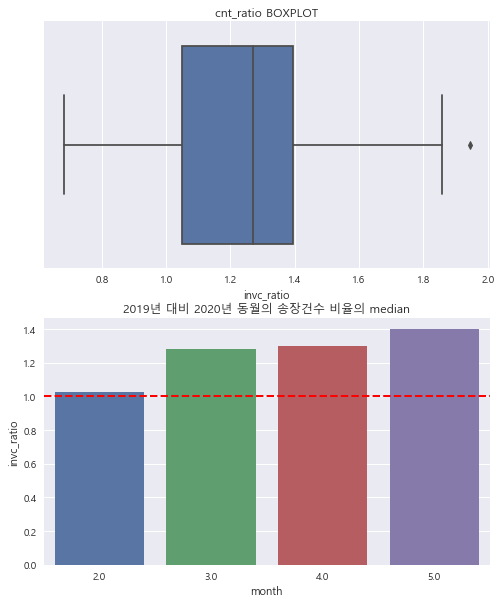

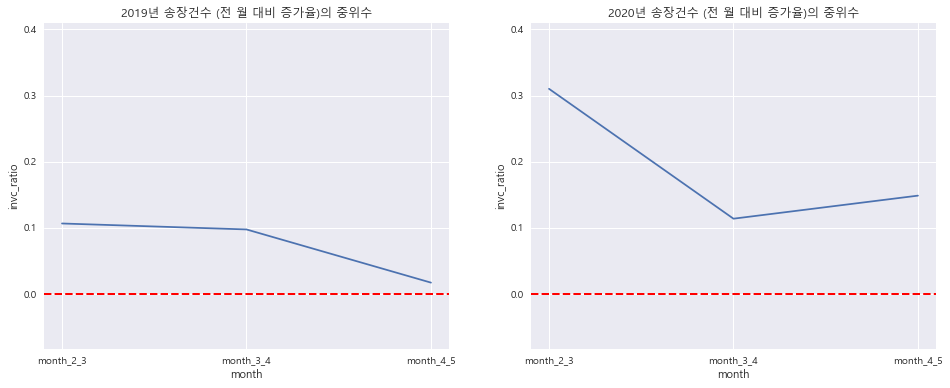

In [77]:
graph_by_year_month_weekday_online(online_category_name)
graph_by_same_month_ratio_online(online_category_name)
graph_by_increase_rate_online(online_category_name)


# 2019년이나 2020년이나 2, 3, 4, 5월 꾸준히 증가하는 추세 (다만, 2020년의 송장건수가 전년 동월 대비 모두 높았다)
# 월요일날 송장건수가 가장 많았다 (아마 주말에 구매하면 송장 등록되는 시점이 월요일이라서 그런 듯!)
# 2019년 대비 2020년 동월의 송장건수 모두 1 이상 (2, 3, 4, 5월)
# 2월 대비 3월 증가율 : 2019년 10% < 2020년 30%
# 3월 대비 4월 증가율 : 10%으로 비슷
# 4월 대비 5월 증가율 : 2019년 2% < 15%

---
## 4. 코로나 신규 확진자수 추이

In [78]:
def graph_corona_time_plot(link):
    corona = pd.read_excel(link)
    corona.fillna(0, inplace=True)
    corona['합'] = corona.drop(['날짜', '검역 누적'], axis=1).sum(axis=1)
    corona['합'] = corona['합'] - corona['합'].shift(1)
    corona['합'].fillna(0, inplace=True)
    corona = corona.set_index("날짜")
    
    max_date = corona.index[corona['합'].argmax()]
    max_date_num_week = max_date.isocalendar()[1]

    ax = corona[['합']].plot(figsize=(16, 6))
    ax.axvline(x=corona['합'].argmax(), color='r', linewidth=2, linestyle='--')
    plt.text(x=corona['합'].argmax(), 
             y=corona['합'].max()*0.9, 
             s='　코로나 신규 확진자수 MAX \n　{} - {}주차'.format(max_date, max_date_num_week), 
             fontsize=14)
    plt.title("코로나 신규확진자수 (한국)", fontsize=14)
    plt.show()

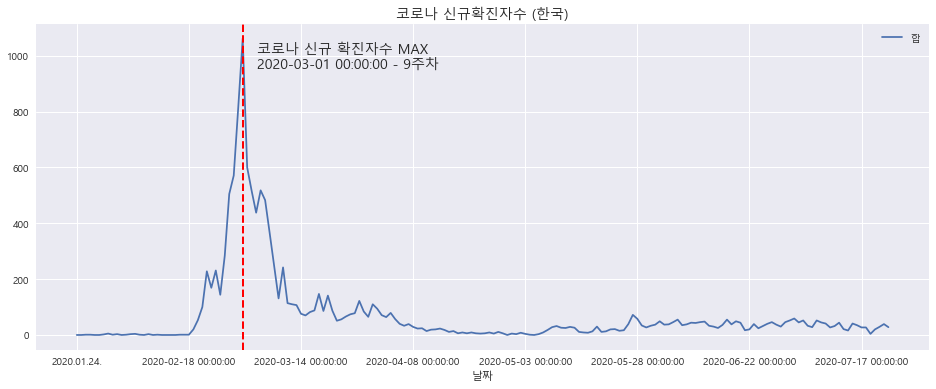

In [79]:
graph_corona_time_plot("data/지역별누적-확진자.xlsx")

---
## 5. 주차별 소비

In [113]:
online.head()

DL_YMD DL_GD_LCLS_NM  DL_GD_LCLS_CD CTPV_NM  CTPV_CD CTGG_NM  CTGG_CD  \
0  190201         도서/음반             12   서울특별시       11      중구       14   
1  190201       가구/인테리어             10   서울특별시       11      중구       14   
2  190201       가구/인테리어             10   대구광역시       27      중구       11   
3  190201         도서/음반             12   대구광역시       27      중구       11   
4  190201        디지털/가전             13   대구광역시       27     수성구       26   

  HDNG_NM  HDNG_CD  INVC_CONT WEEKDAY  YEAR  MONTH  YEAR_MONTH  WEEK_NUM  
0     동화동      665         16     4_금  2019      2      201902         5  
1     신당동      615          4     4_금  2019      2      201902         5  
2    성내1동      565          1     4_금  2019      2      201902         5  
3    남산2동      650          6     4_금  2019      2      201902         5  
4    고산3동      690         21     4_금  2019      2      201902         5

In [114]:
def graph_by_weeknum_online(category_name, aggregate_column):
    week_df = online.groupby(['DL_GD_LCLS_NM', 'CTPV_NM', 'CTGG_NM', 'YEAR', 'WEEK_NUM'])[[aggregate_column]].mean().reset_index()
    week_df = week_df.groupby(['DL_GD_LCLS_NM', 'YEAR', 'WEEK_NUM'])[[aggregate_column]].sum().reset_index()
    week_df = week_df.loc[week_df['DL_GD_LCLS_NM']==category_name, :]

    max_date_num_week = datetime(2020, 3, 1).isocalendar()[1]
    disaster_support_date_num_week = datetime(2020, 5, 13).isocalendar()[1]

    plt.figure(figsize=(16, 5))
    ax = sns.lineplot(x='WEEK_NUM', y=aggregate_column, hue='YEAR', data=week_df, palette="Set2")
    ax.set_xticks([5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])
    ax.legend([2019, 2020])
    ax.axvline(x=max_date_num_week, color='r', linewidth=2, linestyle='--')
    ax.axvline(x=disaster_support_date_num_week, color='g', linewidth=2, linestyle='--')
    ax.set_ylim([0, week_df[aggregate_column].max()*1.1])
    ax.text(x=max_date_num_week, 
         y=week_df.query('YEAR==2020')[aggregate_column].min(), 
         s='　코로나 신규 확진자수 최고\n　(2020.03.01)',
         fontsize=12)
    ax.text(x=disaster_support_date_num_week, 
         y=week_df.query('YEAR==2020')[aggregate_column].min(), 
         s='　재난지원금\n　(2020.05.13)',
         fontsize=12)
    ax.set_title("주차별 {} {}".format(category_name, aggregate_column.upper()), fontsize=12)

In [126]:
def graph_by_weeknum_offline(category_name, aggregate_column):
    # 지역별 주별 평균을 구하고 -> 이것을 업종별로 합해서 그 업종 추이를 보고자 하였다
    week_df = offline.groupby(['MCT_CAT_CD', 'GU_CD', 'DONG_CD', 'YEAR', 'WEEK_NUM', 'SEX_CD', 'AGE_CD'])[[aggregate_column]].mean().reset_index()
    week_df = week_df.groupby(['MCT_CAT_CD', 'YEAR', 'WEEK_NUM'])[[aggregate_column]].sum().reset_index()
    week_df = week_df.loc[week_df['MCT_CAT_CD']==category_name, :]
    
    max_date_num_week = datetime(2020, 3, 1).isocalendar()[1]
    disaster_support_date_num_week = datetime(2020, 5, 13).isocalendar()[1]

    plt.figure(figsize=(16, 5))
    ax = sns.lineplot(x='WEEK_NUM', y=aggregate_column, hue='YEAR', data=week_df, palette="Set2")
    ax.set_xticks([5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])
    ax.legend([2019, 2020])
    ax.axvline(x=max_date_num_week, color='r', linewidth=2, linestyle='--')
    ax.axvline(x=disaster_support_date_num_week, color='g', linewidth=2, linestyle='--')
    ax.set_ylim([0, week_df[aggregate_column].max()*1.1])
    ax.text(x=max_date_num_week, 
         y=week_df.query('YEAR==2020')[aggregate_column].min(), 
         s='　코로나 신규 확진자수 최고\n　(2020.03.01)',
         fontsize=12)
    ax.text(x=disaster_support_date_num_week, 
         y=week_df.query('YEAR==2020')[aggregate_column].min(), 
         s='　재난지원금\n　(2020.05.13)',
         fontsize=12)
    ax.set_title("주차별 {} {}".format(category_name, aggregate_column.upper()), fontsize=12)
    
    
def graph_by_weeknum_with_hue_offline(category_name, aggregate_column, hue_column):
    week_df = offline.groupby(['MCT_CAT_CD', 'GU_CD', 'DONG_CD', 'YEAR', 'WEEK_NUM', 'SEX_CD', 'AGE_CD'])[[aggregate_column]].mean().reset_index()
    week_df = week_df.groupby(['MCT_CAT_CD', 'YEAR', 'WEEK_NUM', hue_column])[[aggregate_column]].sum().reset_index()
    week_df = week_df.loc[week_df['MCT_CAT_CD']==category_name, :]
    
    max_date_num_week = datetime(2020, 3, 1).isocalendar()[1]
    disaster_support_date_num_week = datetime(2020, 5, 13).isocalendar()[1]

    year_2019_df = week_df.loc[week_df['YEAR']==2019, :]
    year_2020_df = week_df.loc[week_df['YEAR']==2020, :]

    max_date_num_week = datetime(2020, 3, 1).isocalendar()[1]
    disaster_support_date_num_week = datetime(2020, 5, 13).isocalendar()[1]
    hue_columns = list(set(week_df[hue_column]))
    hue_columns.sort()
    len_rows = len(set(week_df[hue_column]))

    fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
    sns.lineplot(x='WEEK_NUM', y=aggregate_column, hue=hue_column, data=year_2019_df, palette="Set2", ax=axes[0])
    sns.lineplot(x='WEEK_NUM', y=aggregate_column, hue=hue_column, data=year_2020_df, palette="Set2", ax=axes[1])
    for i in [0, 1]:
        year = 2019 if i==0 else 2020
        axes[i].set_ylim([0, week_df[aggregate_column].max()*1.1])
        axes[i].legend(loc='lower left')
        axes[i].set_xticks(list(set(week_df['WEEK_NUM'])))
        axes[i].axvline(x=max_date_num_week, color='r', linewidth=2, linestyle='--')
        axes[i].axvline(x=disaster_support_date_num_week, color='g', linewidth=2, linestyle='--')
        axes[i].set_title("{}년도".format(year))

    fig, axes = plt.subplots(nrows=len_rows, figsize=(16, 5*len_rows))
    for i, select in enumerate(hue_columns):
        temp_2019 = year_2019_df.loc[year_2019_df[hue_column]==select, :]
        temp_2020 = year_2020_df.loc[year_2020_df[hue_column]==select, :]

        sns.lineplot(x='WEEK_NUM', y=aggregate_column, data=temp_2019, ax=axes[i], palette='Set2')
        sns.lineplot(x='WEEK_NUM', y=aggregate_column, data=temp_2020, ax=axes[i], palette='Set2')
        axes[i].set_ylim(0, max([temp_2019[aggregate_column].max(), temp_2020[aggregate_column].max()])*1.1)
        axes[i].set_xticks(list(set(week_df['WEEK_NUM'])))
        axes[i].legend([2019, 2020], loc='upper left')
        axes[i].axvline(x=max_date_num_week, color='r', linewidth=2, linestyle='--')
        axes[i].axvline(x=disaster_support_date_num_week, color='g', linewidth=2, linestyle='--')
        axes[i].set_title(select)
        axes[i].text(x=max_date_num_week, 
                     y=min([temp_2019[aggregate_column].min(), temp_2020[aggregate_column].min()]), 
                     s='　코로나 신규 확진자수 최고\n　(2020.03.01)',
                     fontsize=12)
        axes[i].text(x=disaster_support_date_num_week, 
                     y=min([temp_2019[aggregate_column].min(), temp_2020[aggregate_column].min()]), 
                     s='　재난지원금\n　(2020.05.13)',
                     fontsize=12)

    plt.show()

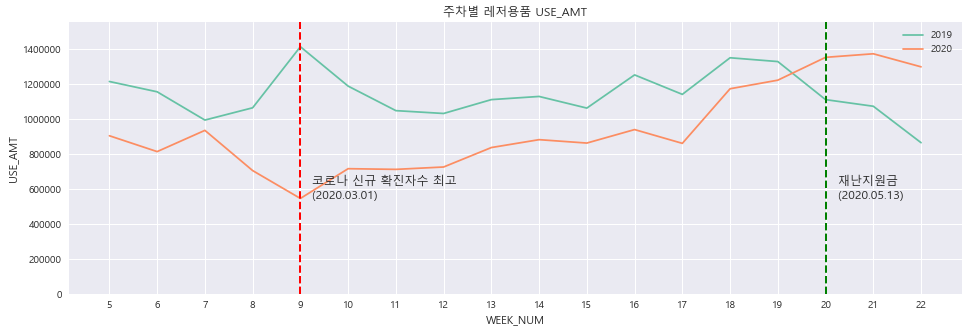

In [109]:
graph_by_weeknum_offline("레저용품", "USE_AMT")

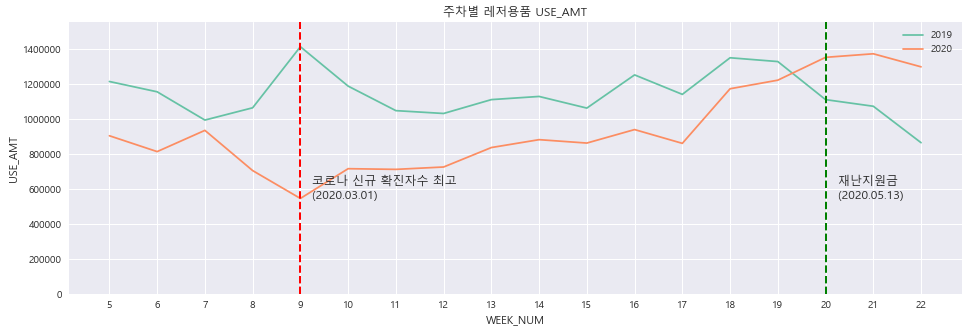

In [112]:
graph_by_weeknum_offline("레저용품", "USE_AMT")

# 코로나로 소비횟수 감소하다가, 
# 신규 확진자수 최고 찍고서는 꾸준히 소비횟수 증가하는 추세이다

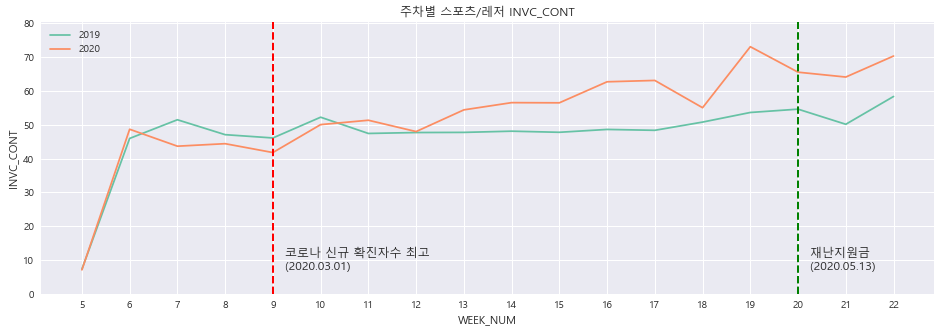

In [116]:
graph_by_weeknum_online("스포츠/레저", "INVC_CONT")

# 송장건수는 작년의 경우 9주차 이후 침체의 형태를 보이는 반면,
# 2020년에는 코로나 이후 꾸준하게 증가하는 추세를 보인다.

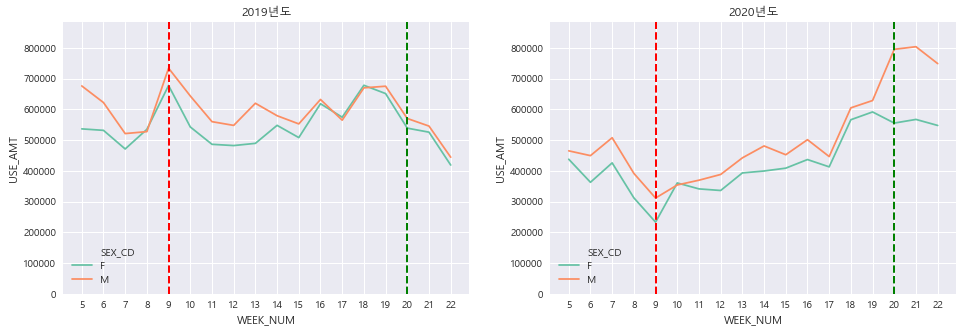

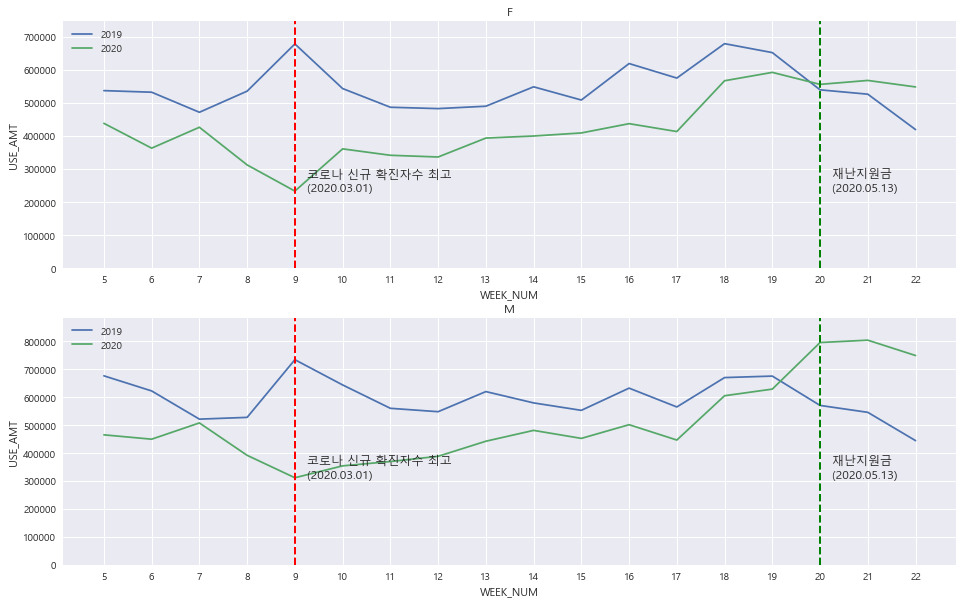

In [127]:
graph_by_weeknum_with_hue_offline("레저용품", "USE_AMT", "SEX_CD")

In [128]:
graph_by_weeknum_with_hue_offline("레저용품", "USE_AMT", "AGE_CD")

---

## 6. 지역별

In [254]:
def graph_by_region_ratio(dataframe, category_name, category_column, gu_column, dong_column, aggregate_column):
    groupby = dataframe.groupby([category_column, gu_column, dong_column, 'YEAR', 'WEEK_NUM'])[[aggregate_column]].mean().reset_index()
    groupby = groupby.query('{}=="{}"'.format(category_column, category_name))

    year_2019 = groupby.query('YEAR==2019')
    year_2019 = year_2019.pivot_table(values=aggregate_column, index=dong_column, columns='WEEK_NUM')
    year_2019.fillna(0, inplace=True)

    year_2020 = groupby.query('YEAR==2020')
    year_2020 = year_2020.pivot_table(values=aggregate_column, index=dong_column, columns='WEEK_NUM')
    year_2020.fillna(0, inplace=True)

    ratio_2020_2019 = (year_2020 / year_2019).fillna(0)
    ratio_2020_2019[ratio_2020_2019 == inf] = 0

    plt.figure(figsize=(16, 0.3*len(set(dataframe[dong_column]))))
    sns.heatmap(ratio_2020_2019, cmap='coolwarm', vmin = -1, vmax = 2, fmt='.2f', annot=True)

In [257]:
graph_by_region_ratio(offline, '레저용품', 'MCT_CAT_CD', 'GU_CD', 'DONG_CD', 'USE_AMT')

In [258]:
graph_by_region_ratio(offline, '레저용품', 'MCT_CAT_CD', 'GU_CD', 'DONG_CD', 'USE_CNT')

In [259]:
graph_by_region_ratio(online, "스포츠/레저", "DL_GD_LCLS_NM", "CTGG_NM", "HDNG_NM", "INVC_CONT")

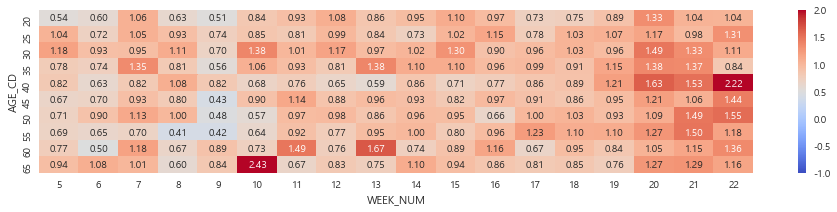

In [255]:
graph_by_region_ratio(offline, '레저용품', 'MCT_CAT_CD', 'DONG_CD', 'AGE_CD', 'USE_AMT')

In [256]:
graph_by_region_ratio(offline, '레저용품', 'MCT_CAT_CD', 'DONG_CD', 'AGE_CD', 'USE_CNT')

## 7. 유동인구와의 관계

In [145]:
flow_201902 = pd.read_csv("data/01_유동인구데이터(SK텔레콤)/4개지역_FLOW_AGE_201902.csv", sep='|')
flow_201903 = pd.read_csv("data/01_유동인구데이터(SK텔레콤)/4개지역_FLOW_AGE_201903.csv", sep='|')
flow_201904 = pd.read_csv("data/01_유동인구데이터(SK텔레콤)/4개지역_FLOW_AGE_201904.csv", sep='|')
flow_201905 = pd.read_csv("data/01_유동인구데이터(SK텔레콤)/4개지역_FLOW_AGE_201905.csv", sep='|')
flow_202002 = pd.read_csv("data/01_유동인구데이터(SK텔레콤)/4개지역_FLOW_AGE_202002.csv", sep='|')
flow_202003 = pd.read_csv("data/01_유동인구데이터(SK텔레콤)/4개지역_FLOW_AGE_202003.csv", sep='|')
flow_202004 = pd.read_csv("data/01_유동인구데이터(SK텔레콤)/4개지역_FLOW_AGE_202004.csv", sep='|')
flow_202005 = pd.read_csv("data/01_유동인구데이터(SK텔레콤)/4개지역_FLOW_AGE_202005.csv", sep='|')
flow = pd.concat([flow_201902, flow_201903, flow_201904, flow_201905, flow_202002, flow_202003, flow_202004, flow_202005], axis=0)

In [302]:
flow = pd.read_csv(os.path.join(csv_file_path,"SK_flow_age_for_card.csv"))

In [303]:
flow = flow.rename(columns = {'year':'YEAR', 'month':'MONTH', 'weekofyear':'WEEK_NUM','dayofweek':'WEEKDAY', 'DONG_NM':'DONG_CD'}).drop('weekday', axis=1)

In [77]:
# flow['WEEK_NUM'] = flow['STD_YMD'].apply(lambda x:datetime.strptime(str(x), '%Y%m%d').isocalendar()[1])

In [148]:
# 카드소비 데이터와 연령 맞추기 위한 전처리
man_under_25 = ['MAN_FLOW_POP_CNT_0004', 'MAN_FLOW_POP_CNT_0509', 'MAN_FLOW_POP_CNT_1014', 'MAN_FLOW_POP_CNT_1519', 'MAN_FLOW_POP_CNT_2024']
wman_under_25 = ['WMAN_FLOW_POP_CNT_0004', 'WMAN_FLOW_POP_CNT_0509', 'WMAN_FLOW_POP_CNT_1014', 'WMAN_FLOW_POP_CNT_1519', 'WMAN_FLOW_POP_CNT_2024']
man_over_65 = ['MAN_FLOW_POP_CNT_6569', 'MAN_FLOW_POP_CNT_70U']
wman_over_65 = ['WMAN_FLOW_POP_CNT_6569', 'WMAN_FLOW_POP_CNT_70U']

flow['MAN_FLOW_POP_CNT_25L'] = flow[man_under_25].sum(axis=1)
flow['WMAN_FLOW_POP_CNT_25L'] = flow[wman_under_25].sum(axis=1)
flow['MAN_FLOW_POP_CNT_65U'] = flow[man_over_65].sum(axis=1)
flow['WMAN_FLOW_POP_CNT_65U'] = flow[wman_over_65].sum(axis=1)

flow.drop(man_under_25+wman_under_25+man_over_65+wman_over_65, axis=1, inplace=True)

In [155]:
groupby_columns = flow.drop(['STD_YM', 'STD_YMD', 'HDONG_CD', 'HDONG_NM', 'WEEK_NUM'], axis=1).columns.tolist()
flow = flow.groupby(['HDONG_NM', 'WEEK_NUM'])[groupby_columns].mean().reset_index()

In [321]:
flow[['DONG_CD','SEX_CD','AGE_CD','YEAR','MONTH','WEEKDAY','WEEK_NUM']].dtypes

DONG_CD     object
SEX_CD      object
AGE_CD       int64
YEAR         int64
MONTH        int64
WEEKDAY     object
WEEK_NUM     int64
dtype: object

In [322]:
offline[['DONG_CD','SEX_CD','AGE_CD','YEAR','MONTH','WEEKDAY','WEEK_NUM']].dtypes

DONG_CD     object
SEX_CD      object
AGE_CD       int64
YEAR         int64
MONTH        int64
WEEKDAY     object
WEEK_NUM     int64
dtype: object

In [320]:
flow['WEEKDAY'] = flow.WEEKDAY.apply(lambda x : '_'.join([str(x),weekdays.get(x)]))

In [324]:
offline

STD_DD   GU_CD DONG_CD MCT_CAT_CD SEX_CD  AGE_CD  USE_CNT  \
0       2019-02-01   대구 중구     동인동         숙박      F      25       11   
1       2019-02-01   대구 중구     동인동         숙박      F      50        5   
2       2019-02-01   대구 중구     동인동         숙박      F      55        5   
3       2019-02-01   대구 중구     동인동         숙박      M      20       11   
4       2019-02-01   대구 중구     동인동         숙박      M      25       11   
...            ...     ...     ...        ...    ...     ...      ...   
2537748 2020-05-31  서울 노원구   상계10동       음료식품      M      45       19   
2537749 2020-05-31  서울 노원구   상계10동       음료식품      M      50       33   
2537750 2020-05-31  서울 노원구   상계10동       음료식품      M      55        9   
2537751 2020-05-31  서울 노원구   상계10동       음료식품      M      60       19   
2537752 2020-05-31  서울 노원구   상계10동       음료식품      M      65        5   

         USE_AMT    AVG_AMT  YEAR  MONTH  DAY  YEAR_MONTH WEEKDAY  WEEK_NUM  
0            595  54.090909  2019      2    1      201902     4_금         5  
1            243  48.600000  2019      2    1      201902     4_금         5  
2             27   5.400000  2019      2    1      201902     4_금         5  
3            243  22.090909  2019      2    1      201902     4_금         5  
4            433  39.363636  2019      2    1      201902     4_금         5  
...          ...        ...   ...    ...  ...         ...     ...       ...  
2537748      127   6.684211  2020      5   31      202005     6_일        22  
2537749      211   6.393939  2020      5   31      202005     6_일        22  
2537750       61   6.777778  2020      5   31      202005     6_일        22  
2537751      194  10.210526  2020      5   31      202005     6_일        22  
2537752       29   5.800000  2020      5   31      202005     6_일        22  

[2537753 rows x 15 columns]

In [338]:
merged_df = offline.merge(flow, on=['DONG_CD','SEX_CD','AGE_CD','YEAR','MONTH','WEEKDAY','WEEK_NUM'], how='outer')
merged_df = merged_df.drop(['STD_DD','STD_YM','HDONG_CD','age','GU_NM','YEAR_MONTH'],axis=1)
merged_df = merged_df.sort_values(by=['DONG_CD','STD_YMD','MCT_CAT_CD','AGE_CD','SEX_CD']).reset_index(drop=True)

### 업종별 유동인구와 소비횟수 상관관계 

1. 상관계수가 높게 나오는 업종 => 유동인구에 민감. 위치에 민감  
2. 상관계수가 높지 않은 업종 => 2-1. 주수요자가 상주인구인 경우, 2-2. 외부에서 목적을 가지고 찾아오는 경우

In [362]:
merged_df['holiday'] = np.where(merged_df.WEEKDAY.apply(lambda x: int(x.split('_')[0])) <5, 0,1)

In [375]:
fp_cnt_corr = {}
for cat in tqdm(merged_df.MCT_CAT_CD.unique().tolist()):
    tmp_dict = {}
    for day in merged_df.WEEKDAY.unique():
        tmp_merged = merged_df.loc[(merged_df.MCT_CAT_CD==cat) & (merged_df.WEEKDAY==day)]
        tmp_dict[day] = tmp_merged.groupby(['STD_YMD'])[['USE_CNT','flow_counts']].sum().corr().iloc[0,1]
    fp_cnt_corr[cat] = tmp_dict
#sorted(fp_cnt_corr.items(), key=lambda x: x[1], reverse=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:08<00:00,  2.86s/it]


In [380]:
fp_cnt_df = pd.DataFrame.from_dict(fp_cnt_corr).T

In [386]:
order = sorted(merged_df.WEEKDAY.unique().tolist(), key=lambda x:int(x.split('_')[0]))

In [388]:
fp_cnt_df = fp_cnt_df[order]

In [400]:
plt.figure(figsize=(10,24))
sns.heatmap(fp_cnt_df, cmap='YlGnBu', annot = True, vmin=.65, vmax=.85)
plt.yticks(rotation=0)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5]), <a list of 24 Text yticklabel objects>)

In [372]:
#주중
fp_cnt_corr = {}
for cat in merged_df.MCT_CAT_CD.unique().tolist():
    tmp_merged = merged_df.loc[(merged_df.MCT_CAT_CD==cat) & (merged_df.holiday ==0)]
    fp_cnt_corr[cat] = tmp_merged.groupby(['STD_YMD'])[['USE_CNT','flow_counts']].sum().corr().iloc[0,1]
sorted(fp_cnt_corr.items(), key=lambda x: x[1], reverse=True)

[('자동차 정비', 0.8925702367278567),
 ('요식업소', 0.8901717390907486),
 ('보건위생', 0.8863159885221457),
 ('가전', 0.8702312799892672),
 ('연료판매', 0.8552814815113976),
 ('신변잡화', 0.841741391329206),
 ('유통업', 0.8353365578927737),
 ('수리서비스', 0.8340352882761336),
 ('의복', 0.8325003569906624),
 ('광학제품', 0.8200955844029296),
 ('숙박', 0.8100566410272408),
 ('전기', 0.8066941552164582),
 ('가구', 0.7974870428628937),
 ('직물', 0.7971878199000508),
 ('서적문구', 0.7844117053365229),
 ('문화취미', 0.7661460279081389),
 ('음료식품', 0.7596789294138823),
 ('자동차판매', 0.7304013770216636),
 ('레저업소', 0.698397224319452),
 ('사무통신', 0.6981156900820144),
 ('주방용구', 0.6970681378370323),
 ('레저용품', 0.6020208197375347),
 ('의료기관', 0.567442960732382),
 (nan, nan)]

In [371]:
#주말
fp_cnt_corr = {}
for cat in merged_df.MCT_CAT_CD.unique().tolist():
    tmp_merged = merged_df.loc[(merged_df.MCT_CAT_CD==cat) & (merged_df.holiday ==1)]
    fp_cnt_corr[cat] = tmp_merged.groupby(['STD_YMD'])[['USE_CNT','flow_counts']].sum().corr().iloc[0,1]
sorted(fp_cnt_corr.items(), key=lambda x: x[1], reverse=True)

[('수리서비스', 0.969348220307563),
 ('신변잡화', 0.9598084503690532),
 ('연료판매', 0.9579941239900093),
 ('보건위생', 0.9541907722976068),
 ('숙박', 0.9485748048935265),
 ('의복', 0.9453488568901386),
 ('요식업소', 0.9416100988881219),
 ('서적문구', 0.9349900882341292),
 ('가전', 0.9305477207469239),
 ('유통업', 0.9284183987321832),
 ('자동차 정비', 0.9274865870860916),
 ('가구', 0.9198922395197133),
 ('전기', 0.9189420268134763),
 ('광학제품', 0.8933066397871384),
 ('주방용구', 0.8705766279751163),
 ('자동차판매', 0.8605937790684802),
 ('문화취미', 0.8467251100349356),
 ('직물', 0.8431484290865622),
 ('의료기관', 0.8408038095346361),
 ('레저업소', 0.8318422172970219),
 ('음료식품', 0.8307309028082251),
 ('레저용품', 0.8193415984122101),
 ('사무통신', 0.7165267734165052),
 (nan, nan)]

### 평균 주말유동인구가 주중유동인구보다 많은 경우

In [194]:
#평균 주말유동인구가 주중유동인구보다 많은 경우
# flow_counts > 0 = 주말유동인구 > 주중유동인구
# flow_counts < 0 = 주말유동인구 < 주중유동인구
flow['holiday'] = np.where(flow.WEEKDAY <5, 0,1)
tmp_df = flow.groupby(['DONG_NM','YEAR'])['flow_counts'].mean().reset_index()

"""
tmp_df['flow_counts'] = flow.groupby(['DONG_NM','YEAR','holiday'])['flow_counts'].mean().\
                            reset_index().\
                            groupby(['DONG_NM','YEAR']).diff().\
                            dropna().\
                            reset_index(drop=True).flow_counts
                """

tmp_df = flow.groupby(['DONG_NM','YEAR','holiday'])['flow_counts'].mean().\
                            reset_index().\
                            groupby(['DONG_NM','YEAR']).\
                            apply(lambda x : (x.iloc[1,-1]-x.iloc[0,-1])/x.iloc[0,-1]).\
                            reset_index(name='fp_per_weekday')

In [182]:
more_fp_in_weekend = tmp_df.query('YEAR==2019 & flow_counts>0').DONG_NM.tolist()

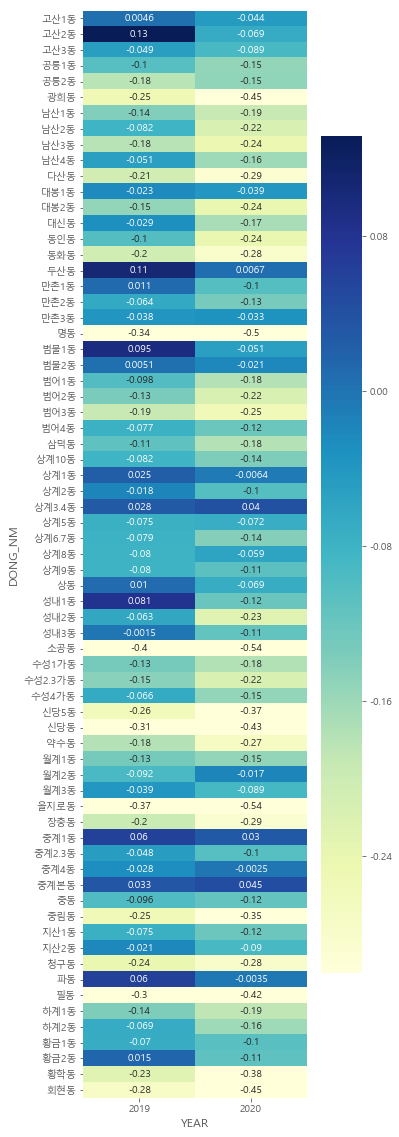

In [215]:
plt.figure(figsize=(5,20))
sns.heatmap(tmp_df.pivot('DONG_NM','YEAR','fp_per_weekday'), cmap='YlGnBu', annot=True, vmin=-.3)

In [401]:
!pip freeze

absl-py==0.7.1
astor==0.8.0
astroid==2.3.3
astropy==4.0
atomicwrites==1.3.0
attrs==19.1.0
autograd==1.3
autograd-gamma==0.4.1
autopep8==1.4.4
backcall==0.1.0
beautifulsoup4==4.8.1
bleach==3.1.0
boto==2.49.0
boto3==1.9.197
botocore==1.12.197
bs4==0.0.1
cachetools==3.1.1
certifi==2019.6.16
chardet==3.0.4
cloudpickle==1.2.1
cmdstanpy==0.4.0
colorama==0.4.1
confuse==1.0.0
convertdate==2.2.0
cycler==0.10.0
Cython==0.29.16
dask==2.2.0
decorator==4.4.0
defusedxml==0.6.0
descartes==1.1.0
docutils==0.14
drawnow==0.72.0
entrypoints==0.3
ephem==3.7.7.1
et-xmlfile==1.0.1
fire==0.3.1
fsspec==0.4.0
future==0.17.1
gast==0.2.2
gensim==3.8.0
google==2.0.2
google-auth==1.7.1
google-auth-oauthlib==0.4.1
google-pasta==0.1.7
grpcio==1.25.0
h5py==2.9.0
holidays==0.10.2
htmlmin==0.1.12
hyperopt==0.1.2
idna==2.8
imbalanced-learn==0.5.0
imblearn==0.0
implicit==0.4.2
importlib-metadata==1.5.0
ipykernel==5.1.2
ipython==5.5.0
ipython-genutils==0.2.0
ipywidgets==7.5.0
iso8601==0.1.12
isort==4.3.21
jdcal==1.4.1
jed

### 신당동은 주말과 주중간 왜 이렇게 차이가 많이 나는지?

신당동에 학교들이 많이 있는데 학생들 유동인구가 영향을 미치는가? X

In [197]:
tmp_181 = flow.query('DONG_NM==\'신당동\'')

In [210]:
tmp_181.head()

STD_YM     STD_YMD    HDONG_CD DONG_NM                    age  \
50610  201902  2019-02-01  1114061500     신당동  MAN_FLOW_POP_CNT_0004   
50611  201902  2019-02-01  1114061500     신당동  MAN_FLOW_POP_CNT_0509   
50612  201902  2019-02-01  1114061500     신당동  MAN_FLOW_POP_CNT_1014   
50613  201902  2019-02-01  1114061500     신당동  MAN_FLOW_POP_CNT_1519   
50614  201902  2019-02-01  1114061500     신당동  MAN_FLOW_POP_CNT_2024   

       flow_counts  YEAR  MONTH  WEEKNUM  WEEKDAY SEX_CD  AGE_CD  GU_NM  \
50610         0.00  2019      2        5        4      M      20  서울 중구   
50611        63.83  2019      2        5        4      M      20  서울 중구   
50612       196.94  2019      2        5        4      M      20  서울 중구   
50613       802.75  2019      2        5        4      M      20  서울 중구   
50614      2421.47  2019      2        5        4      M      20  서울 중구   

       holiday  
50610        0  
50611        0  
50612        0  
50613        0  
50614        0

In [214]:
tmp_181.groupby(['YEAR','holiday','AGE_CD'])['flow_counts'].mean().\
        reset_index().\
        groupby(['YEAR','AGE_CD']).\
        apply(lambda x : (x.iloc[1,-1]-x.iloc[0,-1])/x.iloc[0,-1]).\
        reset_index(name='fp_per_weekday').\
        pivot('YEAR','AGE_CD','fp_per_weekday')

AGE_CD        20        25        30        35        40        45        50  \
YEAR                                                                           
2019   -0.136725 -0.241307 -0.318897 -0.390888 -0.401045 -0.390500 -0.343944   
2020   -0.110468 -0.340047 -0.429284 -0.511553 -0.525074 -0.507574 -0.450537   

AGE_CD        55       60        65  
YEAR                                 
2019   -0.308212 -0.29839 -0.253456  
2020   -0.431843 -0.40698 -0.379719

25세이하에서 유동인구 변화율이 가장적었음  
=> 주중에 유동인구가 많은것인지, 주말에 유동인구가 적은것인지?